## Automação de Área Trabalhada - Silvicultura (DEPLA-P + DESIL-N)

Sistemas de identificação de operação e área efetiva trabalhada em conjunto com detalhamento de data e hora final de operação auxiliam o gestor a entender os processos florestais que muitas vezes sofrem por equipamentos que nao estão atualizados a disponibilizar tais informações.

Atualmente a CENIBRA dispoem de tratores e maquináros que contam com equipamentos que medem o tipo de levantamento elencado por este trabalho e outras informações mais apuradas, mas o contrato dos mesmos e o suporte gera um elevado custo no montante final da operação silvicultural.

Deste modo, o DEPLA-P em conjunto com o DESIL-N, desenvolveu uma ferramenta que elenca tais informações com equipamentos e *softwares* que já estão disponíveis para utilização na CENIBRA. Tanto a disponibilização de mapas como o levantamento de informações é realizado atraves do *GisAgri* que é um suite de ferramentas de gestão de processos florestais que ajuda na governança das informações e rastreabilidade, ligado ao banco de dados da empresa.

Já o processamento dos dados capturados é feita pelo *software ArcGis Pro*, que conta com integração total a plataforma de captura e disponibilização de mapas online.

### 1. Importação de pacotes e modulos para o ambiente de trabalho.

> **Módulos:** Sao arquivos que contem funções e definições pré estabelecidas para utilização do usuário de forma a modularizar o codigo. Isto torna a interação do desenvolvedor muito mais facil para entendimento e limpeza do script. Sem mencionar a re-utilização de um mesmo módulo em varios scripts diferentes.

> **Pacotes:** São um conjunto de funções e definições, em sua essencia modulos com diferentes funcionalidades. Podemos criar pacotes diferentes de acordo com nosso intuito de trabalho ou importar pacotes pré criados, como o `Arcpy`, pacote nativo do *ArcGis Pro*

**Nota:** O Arcgis estabelece as definições de modulo e pacote trocadas.

In [229]:
# Importação dos pacotes para o ambiente virtual
# Pacotes nativos do ArcGis
import arcpy
from arcpy.sa import *
from arcpy import env
# Pacote de datas
from datetime import datetime, timedelta
# Pacote para geração de chaves randomicas
import random
import string
# Pacote para envio de email
import smtplib
import csv
import pandas as pd
# Limite indeterminado para colunas e linhas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Sobreposição de arquivos gerados na database
arcpy.env.overwriteOutput = True

### 2. Compreção da base de dados e Reconciliamento.

A definição no começo da *string* com a letra `r`, significa que a mesma será tratada como *raw string*. Podemos observar o tratamento do caminho definido na documentação do Python 2 sobre *String Literas* (https://docs.python.org/2/reference/lexical_analysis.html#string-literals).

In [2]:
# Identificação do caminho da sde para o Compress
sde = r"\\cnbbogis01\runtime\sde_publisher@prd.sde"

**Compress, melhores práticas**

> Melhora a performance e eficiencia da geodatabase;

> Uma vez a gdb/sde comprimida, registros deletados nao podem ser recuperados;

> Uma gd/sde comprimida nao apenas reduz o requerimento de espaço mas tambem reduz o tempo de tentativa para conseguir importar os dados;

> Esta ferramenta nao é utilizada a gdb Enterprise que nao utiliza versionamento.

**Versionamento**

Em cenários de utilização de base de multi usuários, as versões permitem trabalhar com o mesmo dado ao mesmo tempo sem a aplicação de lock ou duplicação dos dados, provendo cada editor seu dado unico, e isolado. Quando a edição é finalizada a versão é então unida ao dado original de que foi criada.
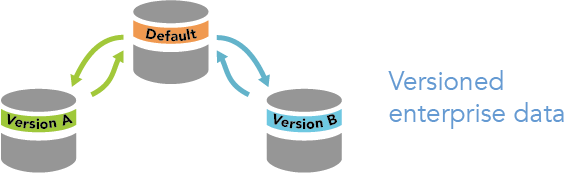

**Tipos de versionamento**

Cada tipo de versionamento disponível é caracterizado por um tipo de workflow.

> Branch versioning: Facilita os modelos em deploy de Web GIS permitindo a edição de multiusuários e transações longas via feature services;

> Traditional versioning: Permite a flexibilidade de trabalhar com versoes para longas transações quando acessados diretamenta da gdb/sde enterprise e fornece uma experiencia simples de edição quando trabalhando com feature services para acomodar transações curtas.
>> Traditional versioning com opção de mover edições para a base: Uma opçao ao versionamento tradicional que permite ao editor e aplicações terem acesso direto a base de dados enquanto outros editores possam trabalhar com suas versoes isoladas.

*Mais info: https://pro.arcgis.com/en/pro-app/2.8/help/data/geodatabases/overview/versioning-types.htm#GUID-272BEE5B-1466-4861-BC94-1F4AB148E235*


Independente do tipo de versionamento todas as versões devem ser registradas para permitir a participação dentro do geodatabase. A partir do momento em que registramos o dados como versionado, podemos começar a trabalgar com nossa versão criando uma ramificação do dado default.

Todas versões criadas da base original são consideradas filhas. Com o decorrer do tempo, as versões divergem a medida que mudanças são feitas quando comparadas a base ancestral e a outras versoes de usuarios. A medida que novas versões são criadas, uma arquitetura em árvore é criada e começa a se desenvolver, isto é chamado de árvore de versões da base.

**Reconciliamento**

Quando a base de dados passa por reconciliamento, as versões filhas de usuários são integradas a versão default.
*OBS.: Quando dois usuários estão trabalhando na mesma base de dados, com duas versões diferentes e diferentes tipos de edições (i.e. numero de linhas), pode ocorrer conflito de reconciliamento. Neste caso o processo permite a escolha do administrados da base de qual versão de usuário deverá ser mantida.*

In [ ]:
# Comprimindo os arquivos da sde, pela remoção dos estados nao referenciados pela versão e valores reduntantes de linhas.
# No geral o compress aumenta a performance e eficiencia da sde
arcpy.management.Compress(sde)

In [ ]:
# Pela lista de compreensao listar as versoes onde o dono é o usuário
# e ter certeza que o sde.default nao é selecionado
verList = [ver.name for ver in arcpy.da.ListVersions(sde) if ver.isOwner == True and ver.name.upper() != 'SDE_PUBLISHER.DEFAULT']

In [ ]:
# Reconciliamento de versoes detecta diferenças entre as edições de versao e as versoes alvo e 
# realiza um flag da diferença como conflitantes
print("Iniciando reconciliamento de versões....")
arcpy.management.ReconcileVersions(sde, "ALL_VERSIONS", "SDE_PUBLISHER.DEFAULT", verList, "LOCK_ACQUIRED", "NO_ABORT",
                                   "BY_OBJECT", "FAVOR_TARGET_VERSION", "POST", "DELETE_VERSION")
print("Reconciliamento de versões concluido!")

### 3. Identificação de base de dados.

As novas linhas geradas pelos operadores do mapa disponibilizado pelo GisAgri serão selecionadas de acordo com uma chave de identificação. Como padrão as linhas criadas contém um campo denominado **ID_REGRA**, no qual, é nulo quando a base passa pelo reconciliamento de versões.

As linhas identificadas na base de dados com o campo **ID_REGRA** nulo são selecionadas para os devidos tratamentos e operações com a finalidade do cálculo de área efetiva da operação de silvicultura.

A criação da regra chave para os campos nulos segue por determinação randomica de tamanho de 10 caracteres pela palavra `SiLvIcUlTuRaCeLuLoSeNiPoBrAsIlEiRaSa08032022`.

**Buffer de operações**

Cada operação apresenta uma distancia efetiva de trabalho da linha de coleta, também foi considerado o erro do sinal de GPS em um diametro de 3 metros. As operações, descrições e distancia de área efetiva trabalhada sem considerar o erro são descritas abaixo.

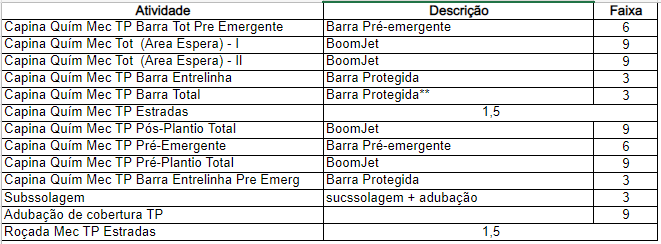

In [3]:
# Set da gdb de trabalho (local de criação da trash bin)
arcpy.env.workspace = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb"

In [4]:
# Identificação dos datasets Linhas Silvicultura e Poligonos do Uso Solo
linhas = r"\\cnbbogis01\runtime\sde_publisher@prd.sde\SDE_PUBLISHER.Editavel_Silvicultura\SDE_PUBLISHER.Silvicultura_Linha"
solo = r"\\cnbbogis01\runtime\sde_publisher@prd.sde\SDE_PUBLISHER.CAD_USO_SOLO_PROPRIO"

In [5]:
# Seleção de linhas recem adicionadas
z = arcpy.management.SelectLayerByAttribute(linhas, "NEW_SELECTION", 'ID_REGRA is Null')

In [6]:
# Atualização dos valores do field Buffer de acordo com operação
fc = arcpy.UpdateCursor(linhas)
for row in fc:
    row.ID_REGRA = ''.join(random.choice('SiLvIcUlTuRaCeLuLoSeNiPoBrAsIlEiRaSa08032022') for _ in range(10))
    fc.updateRow(row)
    if row.getValue("OPERACAO") == '1':
        row.BUFFER = '9'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '2':
        row.BUFFER = '12'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '3':
        row.BUFFER = '12'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '4':
        row.BUFFER = '6'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '5':
        row.BUFFER = '6'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '6':
        row.BUFFER = '5'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '7':
        row.BUFFER = '12'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '8':
        row.BUFFER = '9'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '9':
        row.BUFFER = '12'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '10':
        row.BUFFER = '6'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '11':
        row.BUFFER = '6'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '12':
        row.BUFFER = '12'
        fc.updateRow(row)
    if row.getValue("OPERACAO") == '13':
        row.BUFFER = '5'
        fc.updateRow(row)
    
        
del row
del fc
print('Atualização dos dados da tabela de atributos concluida!! :)')

Atualização dos dados da tabela de atributos concluida!! :)


### 4. Criação de poligonos e exportação de dados.

 Como `z` foi definido para seleção de valores nulos que foram adicionados recentemente a base de dados, o numero de linhas em `z` servirá para identificação da quantidade de linhas que serão trabalhadas.
 
 Para o quantitativo do arcgis ele leva em consideração a linha de header da tabela de atributos como uma linha, logo, se `z` for maior que 1, será identificado que linhas foram criadas e a análise será continuada.
 
**Em continuação ao processo:**

> Criação do buffer de linhas de forma variável por tipo de operação + erro gps;

> Clip de poligonos gerados pelo buffer pelo poligono de uso de solo proprio (remoção de poligonos em estrada);

> Explosão de poligonos clipados para identificação de cada um de forma unica;

> Junção espacial de poligonos explodidos com os poligonos que estão sobrepostos de uso do solo para extração de informações categoricas e ordinais;

> Cálculo de área dos poligonos;

> Sumarização das áreas calculadas de poligonos para identificação do poligono com maior área;
*Os polignos para cada linha de maior área serão os considerados como o correto. Por que? A criação dos buffers de operações podem gerar pedaços de poligonos que apos o clip e explosão fiquem de fora do talhão, nao representam de fato uma área trabalhada durante a operação de silvicultura. Logo, as maiores áreas estarão de fato dentro da área trabalhada.*

> Seleção de poligonos com maiores áreas e dissolve dos mesmos de acordo com a operação e o REF_ID do talhão;

> Junção espacial dos poligonos dissolvidos com as linhas submetidas pelos usuários para extração de data e hora de trabalho *OBS.: Remoção `timedelta(UTC-3)` pois todos horarios são considerados em outro fuso dentro da plataforma ArcGis*;

> Adição de descrição da operação de acordo com ID do dominio pré cadastrado para apontamento de usuários;

> Remoção de campos que nao serão necessários para o mapa final;

> Alteração de nomeclatura de atributos da coluna;

> Criação de novo campo para label *O mesmo aparece cada coluna de interesse em uma nova linha*;

> Append dos dados análisados e gerados ao mosaico de operações de silvicultura atual.


**Envio de e-mails via SMTP**

Após a análise e devida contabilização de poligonos criados, um email é disparado para os contatos pré cadastrados informando o REF_ID de onde a área foi trabalhada, o tipo de operação, a data e hora em que foi sincronizado a linha no sistema e a área total do poligono em hectares.


In [7]:
# Criação de copia das linhas a serem trabalhadas
att = arcpy.CopyFeatures_management(z)
att1 = arcpy.management.GetCount(att)

In [8]:
if int(att1[0]) == 1:
    print('Nenhuma nova linha cadastrada. Encerrando o processamento.')
    pass
if int(att1[0]) > 1:
    # Buffer de linhas Silvicultura por tamanho variavel (de acordo com operação - vide planilha)
    buff = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\buffer"
    arcpy.analysis.Buffer(att, buff, "BUFFER")
    
    # Clip das áreas "bufferizadas" com poligonos de uso do solo
    clip = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\clip"
    arcpy.analysis.Clip(buff, solo, clip)
    
    # Explosão dos poligonos clipados de acordo com uso do solo
    exploded = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\exploded"
    arcpy.management.MultipartToSinglepart(clip, exploded)
    
    # Fetch de dados do cadastro de uso do solo
    expl = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\exploded_joined"
    arcpy.analysis.SpatialJoin(exploded, solo, expl, "JOIN_ONE_TO_ONE", "", "", "LARGEST_OVERLAP")
    
    # Calculo geometrico de área dos poligonos clipados em m2
    arcpy.management.AddGeometryAttributes(expl, "AREA", "", "SQUARE_METERS")
    
    # Summarize para encontrar as maiores áreas de acordo com ID de origem
    # Racionalmente, maiores áreas de poligono serão as que nao sobreporam areas fora da área de manejo "erroneamente"
    selection = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\selection"
    arcpy.Statistics_analysis(expl, selection,[['POLY_AREA', 'MAX']], 'ORIG_FID' )
    
    print("Dissolvendo poligonos gerados...")
    # Conversão do .dbf summarizado em lista
    myList = [row[0] for row in arcpy.da.SearchCursor(selection, 'MAX_POLY_AREA')]

    if len(myList) > 1:
        # Seleção de áreas completamente processadas
        qry = 'POLY_AREA IN {0}'.format(tuple(myList))
        areas = arcpy.management.SelectLayerByAttribute(expl, "NEW_SELECTION", qry)
        # Exportar copia de features selecionadas
        sample = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\sample"
        x = arcpy.CopyFeatures_management(areas, sample)
        # Dissolve de áreas de acordo com tipo de operação
        dissolved = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\Mosaico_Mec_silvicultura"
        arcpy.management.Dissolve(x, dissolved, ['OPERACAO', 'REF_ID'])
    if len(myList) == 1:
        dissolved = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\Mosaico_Mec_silvicultura"
        arcpy.management.Dissolve(expl, dissolved, ['OPERACAO', 'REF_ID'])

    print("Poligonos dissolvidos com sucesso!")
    
    
    # Interseção dos poligonos criados com as linhas levantadas
    join2 = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\join2"
    arcpy.analysis.SpatialJoin(dissolved, linhas, join2, "JOIN_ONE_TO_ONE", "", "", "LARGEST_OVERLAP")
    
    # Atualização das horas trabalhadas para nosso Fuso horário (UTC -03:00)
    fc = arcpy.UpdateCursor(join2)
    for row in fc:
        row.CREATED_DATE = row.getValue('CREATED_DATE') - timedelta(hours=3)
        fc.updateRow(row)
    
    del fc
    del row


    # Adição de descrição da operação de acordo com ID do Domain
    x = r"\\cnbbogis01\runtime\Temporários\Leonardo\Silvicultura.gdb\join2"
    fc = arcpy.UpdateCursor(x)
    for row in fc:
        if row.getValue("Operacao") == str(1):
            row.Operacao = 'Capina Quím Mec TP Barra Tot Pre Emergente'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(2):
            row.Operacao = 'Capina Quím Mec Tot  (Área Espera) - I'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(3):
            row.Operacao = 'Capina Quím Mec Tot  (Área Espera) - II'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(4):
            row.Operacao = 'Capina Quím Mec TP Barra Entrelinha'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(5):
            row.Operacao = 'Capina Quím Mec TP Barra Total'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(6):
            row.Operacao = 'Capina Quím Mec TP Estradas'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(7):
            row.Operacao = 'Capina Quím Mec TP Pós-Plantio Total'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(8):
            row.Operacao = 'Capina Quím Mec TP Pré-Emergente'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(9):
            row.Operacao = 'Capina Quím Mec TP Pré-Plantio Total'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(10):
            row.Operacao = 'Capina Quím Mec TP Barra Entrelinha Pré Emergente'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(11):
            row.Operacao = 'Subssolagem'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(12):
            row.Operacao = 'Adubação de cobertura TP'
            fc.updateRow(row)
        if row.getValue("Operacao") == str(13):
            row.Operacao = 'Roçada Mec TP Estradas'
            fc.updateRow(row)
        
    del row
    del fc
    print('Atualização dos dados da tabela de atributos concluida!! :)')
    
    # Arranjo de campos para join 
    arcpy.management.DeleteField(x, ["Join_Count", "TARGET_FID", "Regiao", "OBSERVACAO", "BUFFER", "ID_REGRA", "CREATED_USER", "LAST_EDITED_USER", "LAST_EDITED_DATE", "OPERACAO_1" ])
    
    arcpy.management.AlterField(x, "SHAPE", "SHAPE", "Shape")
    arcpy.management.AlterField(x, "CREATED_DATE", 'DATA', "Data")
    arcpy.management.AlterField(x, "SHAPE_Length", 'SHAPE.LEN', "SHAPE.LEN")
    arcpy.management.AlterField(x, "SHAPE_Area", 'SHAPE.AREA', "SHAPE.AREA")
    # Criação do campo de área ha
    arcpy.management.AddGeometryAttributes(x, "AREA", "", "HECTARES")
    # Renomear campo calculado de área ha
    arcpy.management.AlterField(x, "POLY_AREA", "AREA_HA", "AREA_HA")
    # Adição de coluna de Labels
    arcpy.management.CalculateField(x, "LABEL", "!OPERACAO!+'''\n'''+str(!AREA_HA!)+'''\n'''+str(!DATA!)", "PYTHON3", '', "TEXT", "NO_ENFORCE_DOMAINS")
    
    
    # Exportação dos poligonos para .gdb (CASO NAO TENHA A FEATURE CRIADA // USADO PARA PRIMEIRO PROCESSAMENTO DE DADOS //)
    #sde = r"X:\sde_publisher@prd.sde\SDE_PUBLISHER.Mosaico_Geral"
    #arcpy.conversion.FeatureClassToGeodatabase(x, sde)
    
    # Mosaico de silvicultura MEC
    mosaico = r"\\cnbbogis01\runtime\sde_publisher@prd.sde\SDE_PUBLISHER.Mosaico_Geral\SDE_PUBLISHER.Mosaico_MEC_Silvicultura"
    # Append de resultados gerados para esta atualização ao mosaico original
    arcpy.management.Append(x, mosaico)
    
    
    # Criação de dataframe com valores de ref_id, operacao e area em hectares para corpo de email
    ref = [row for row in arcpy.da.SearchCursor(x, ["REF_ID", "Operacao", "AREA_HA", "Data"])]
    df = pd.DataFrame(ref, columns=['REF_ID', 'Operacao', "Area (ha)", "Data"])
    # Encode das operações para remoção de acentos e cedilha
    df.Operacao = df['Operacao'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    
    # Envio de email com informações de atualização de linhas
    # Criando sessao SMTP
    smtp = smtplib.SMTP('smtp-mail.outlook.com', 587)
    # Utilização de TLS para segurança
    smtp.starttls()
    # Autenticação de usuário
    smtp.login("CENIBRAGEO@outlook.com.br", "cenibra2022")
    # Definição dos parametros de email
    SUBJECT = "Atualizacao Operacoes Silvicultura - Rotina Automatica de Mecanizacao (DEPLA-P)"
    number = arcpy.management.GetCount(x)
    TEXT = "Ola, \n\nOs dados de operacoes de Silvicultura foram atualizados com sucesso! \n\n{} Poligonos foram registrados para a data{}. \n\n Estes, seguem descritos na tabela abaixo\n\n {}.\n\nAtt,".format(int(number[0]), datetime.today(), df)
    FROM = "leonardo.rodrigues@cenibra.com.br"
    TO = ["leonardo.rodrigues@cenibra.com.br", "tassius.araujo@cenibra.com.br", "guilherme.fernandes@cenibra.com.br"]
        
    # Envelope da mensagem atual
    message = """From: %s\r\nTo: %s\r\nSubject: %s\r\n\

    %s
    """ % (FROM, ", ".join(TO), SUBJECT, TEXT)

    smtp.sendmail(FROM,TO ,message)
    smtp.quit()

Dissolvendo poligonos gerados...
Poligonos dissolvidos com sucesso!
Atualização dos dados da tabela de atributos concluida!! :)
